In [2]:
from cmb_simulation import *
from kymatio.numpy import Scattering2D
import plotly.express as px
import pandas as pd

In [3]:
# getCambSpectra
powers = getCambSpectra()

In [4]:
d = 1/60/180*np.pi
N = 512
cmb = CMBSpectra(powers)
teb = cmb.generatePrimordialMaps(d, N)
p = cmb.generateLensingPotential(d, N)
teb_len = lensTEB(teb, p, lensTaylorNearest)
detector = Detector(*cmb_s4_params)

In [5]:
J = 8 # 2^J <= 512
N = 512
S = Scattering2D(J, (N, N), out_type='list')

In [6]:
def qeCircularStrings(teb, A, r, n, lmin, lmax, lensed=True):
    N = teb.N
    a = CMBMap(d, N, real=rotationFromCircularStrings(N, A, r, n))
    teb_rot = rotateTEB(teb, a)
    teb_rot_obs = detector.addNoise(teb_rot)
    qe_rot = RotationEstimator(cmb, teb_rot_obs, detector, lensed=lensed)
    qe_rot_EB = qe_rot.evaluateQE('EB', lmin, lmax) # generalise this
    return qe_rot_EB

In [7]:
# j1 < j2
# average over thetas, average over real map pixels, plot ln(s2/s1) as a function of j2 for each j1

def reducedCoef(Sx):
    '''
    Sx : list of dicts
        Output of Scattering2D in list mode, applied to a real map
    '''
    # collect all unique j
    # make temp array for each unique j
    # average into a single reduced coef
    uniq_j1 = set([sx['j'] for sx in Sx if len(sx['j']) == 1]) # first-order
    uniq_j2 = set([sx['j'] for sx in Sx if len(sx['j']) == 2]) # second-order
    ret1 = dict()
    ret2 = dict()
    for j in uniq_j1:
        arr = np.array([sx['coef'] for sx in Sx if sx['j'] == j])
        ret1[j] = np.mean(arr)
    for jj in uniq_j2:
        arr = np.array([sx['coef'] for sx in Sx if sx['j'] == jj])
        ret2[jj] = np.mean(arr)
    return ret1, ret2

def log_s2s1(s1, s2):
    J = len(s1)
    ret = []
    for j1 in range(J-1):
        s1j = s1[(j1,)]
        s2jj = np.array([s2[(j1, j2)] for j2 in range(j1+1, J)])
        ret.append(np.log(s2jj / s1j))
    return ret

In [10]:
params = [(A, r, n) for A in [1/10, 1/2, 1] for r in [100, 300, 800] for n in [1, 10, 50]]
df_pre = {'A': [], 'r': [], 'n': [], 'j1': [], 'j2': [], 'log_s2s1': []}
for p in params:
    A, r, n = p
    qe_rot_EB = qeCircularStrings(teb_len, A=A, r=r, n=n, lmin=5, lmax=3000, lensed=True).r
    log_red_coef = log_s2s1(*reducedCoef(S(qe_rot_EB)))
    J = log_red_coef[0].size + 1
    for j1 in range(J-1):
        for j2 in range(j1+1, J):
            df_pre['A'].append(A)
            df_pre['r'].append(r)
            df_pre['n'].append(n)
            df_pre['j1'].append(j1)
            df_pre['j2'].append(j2)
            df_pre['log_s2s1'].append(log_red_coef[j1][j2-j1-1])
df = pd.DataFrame(df_pre)

In [16]:
px.line(df[(df['A']==1) & (df['r']==800)], x='j2', y='log_s2s1', color='n', line_group='j1')

In [24]:
def plotReducedCoefs(reduced_coefs, fmt):
    J = reduced_coefs[0].size + 1
    for j1 in range(J-1):
        j2s = np.arange(j1+1, J)
        plt.plot(j2s, reduced_coefs[j1], fmt)
    plt.xlabel('$j_2$')
    plt.ylabel('$\ln s_2/s_1$')

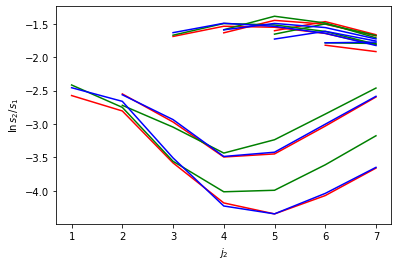

In [26]:
# use plotly here

plotReducedCoefs(reduced_coefs[(0.1, 100, 10)], 'r')
plotReducedCoefs(reduced_coefs[(0.1, 300, 10)], 'g')
plotReducedCoefs(reduced_coefs[(0.1, 800, 10)], 'b')

In [ ]:
# maybe make a random gaussian map based on the measured alpha-alpha power spectrum,
# and see if the coefs are any different (i.e. non-gaussianity is captured)